In [1]:
import os
import sys
import pandas as pd
sys.path.insert(0, "../../")
from src.text.epu import EPU

In [2]:
target_folder = sys.path[0] + "/data/text/samoa/"
target_files = [target_folder + file for file in os.listdir(target_folder) 
                if "news" in file]

In [3]:
samoa_stats = pd.DataFrame()
for file in target_files:
    samoa = EPU(file)
    samoa.get_epu_category()
    samoa_stat = samoa.get_epu_stats(cutoff="2020-01-01")
    if samoa_stats.empty:
        samoa_stats = samoa_stat
    else:
        samoa_stats = samoa_stats.merge(samoa_stat, how="outer", on="date")

In [4]:
samoa_stats = samoa_stats[samoa_stats.date >="2015-02-01"].fillna(0)
samoa_stats["z_score"] = samoa_stats[["z_score_x", "z_score_y"]].mean(axis=1)

<Axes: xlabel='date'>

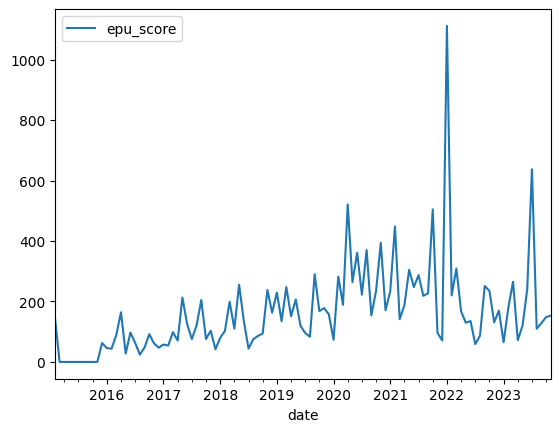

In [5]:
scaling_factor = 100/samoa_stats[samoa_stats.date < "2020-01-01"]["z_score"].mean()
samoa_stats["epu_score"] = scaling_factor * samoa_stats["z_score"]
samoa_stats.plot(x="date", y="epu_score")

In [10]:
so = samoa.raw
so = so[(so.econ==True) & (so.policy==True)].reset_index(drop=True)

In [11]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sent_df = pd.DataFrame()
for row in so.news:
    sample = row.replace("\n", " ").strip()
    sid = SentimentIntensityAnalyzer()
    ss = sid.polarity_scores(sample)
    ss_temp = pd.DataFrame(ss, columns=ss.keys(), index=[0])
    sent_df = pd.concat([sent_df, ss_temp], axis=0)

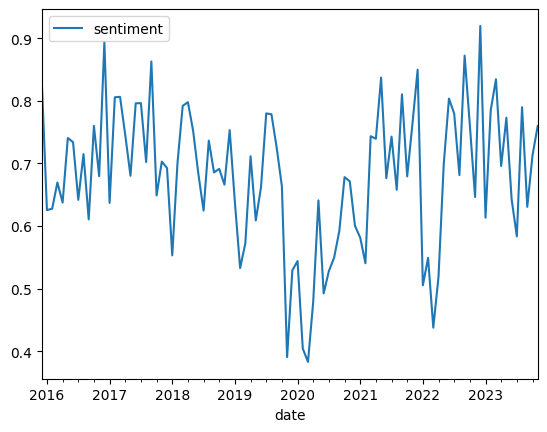

In [19]:
so["sentiment"] = sent_df["compound"].tolist()
so_sent = so.set_index("date").groupby(pd.Grouper(freq="MS"))[["sentiment"]].mean()
so_sent.plot();